In [ ]:
!pip install medpy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 156.3/156.3 kB 12.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.4/52.4 MB 12.0 MB/s eta 0:00:00
  Created wheel for medpy: filename=MedPy-0.5.2-cp310-cp310-linux_x86_64.whl size=762837 sha256=a2fcc2abb7d5e030d960fcd8ad01b5343a2b49a1dc2f295d6127b778d59dbf6a
  Stored in directory: /root/.cache/pip/wheels/a1/b8/63/bdf557940ec60d1b8822e73ff9fbe7727ac19f009d46b5d175
Successfully built medpy


In [ ]:
from google.colab import auth, drive
from googleapiclient.discovery import build

auth.authenticate_user()
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from PIL import Image
import os
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt, cm

from medpy.metric import dc, jc
from medpy.io import load, header

from tqdm import notebook, trange

SEED = 42

In [ ]:
def path(fname, num):
    return f'drive/My Drive/CHAOS/CHAOS_Train_Sets/Train_Sets/CT/' + fname
    # return f'drive/My Drive/Anon_Liver/Anon_Liver/' + fname

def get_data(num):
    X_path = path('', num)
    X_filenames = []

    for directory in notebook.tqdm(os.listdir(X_path)[:-1], position=0):
        for dirName, subdirList, fileList in os.walk(X_path+directory):
            for filename in fileList:
                if ".dcm" in filename.lower():
                    X_filenames.append(os.path.join(dirName, filename))

    return sorted(X_filenames)

In [ ]:
X_filenames1 = get_data(1)
# X_filenames = X_filenames1[:100]
X_filenames = np.random.choice(X_filenames1, size=100, replace=False)


print(X_filenames)

  0%|          | 0/18 [00:00<?, ?it/s]

['drive/My Drive/CHAOS/CHAOS_Train_Sets/Train_Sets/CT/25/DICOM_anon/IMG-0008-00081.dcm'
 'drive/My Drive/CHAOS/CHAOS_Train_Sets/Train_Sets/CT/18/DICOM_anon/i0081,0000b.dcm'
 'drive/My Drive/CHAOS/CHAOS_Train_Sets/Train_Sets/CT/27/DICOM_anon/IMG-0010-00204.dcm'
 'drive/My Drive/CHAOS/CHAOS_Train_Sets/Train_Sets/CT/2/DICOM_anon/i0007,0000b.dcm'
 'drive/My Drive/CHAOS/CHAOS_Train_Sets/Train_Sets/CT/5/DICOM_anon/i0073,0000b.dcm'
 'drive/My Drive/CHAOS/CHAOS_Train_Sets/Train_Sets/CT/19/DICOM_anon/i0079,0000b.dcm'
 'drive/My Drive/CHAOS/CHAOS_Train_Sets/Train_Sets/CT/24/DICOM_anon/IMG-0007-00002.dcm'
 'drive/My Drive/CHAOS/CHAOS_Train_Sets/Train_Sets/CT/26/DICOM_anon/IMG-0009-00069.dcm'
 'drive/My Drive/CHAOS/CHAOS_Train_Sets/Train_Sets/CT/21/DICOM_anon/IMG-0001-00040.dcm'
 'drive/My Drive/CHAOS/CHAOS_Train_Sets/Train_Sets/CT/25/DICOM_anon/IMG-0008-00034.dcm'
 'drive/My Drive/CHAOS/CHAOS_Train_Sets/Train_Sets/CT/1/DICOM_anon/i0013,0000b.dcm'
 'drive/My Drive/CHAOS/CHAOS_Train_Sets/Train_Sets

In [ ]:
def buffer_imgs(filenames, folder='buffer'):
    files = []
    if not os.path.exists(folder):
        os.makedirs(folder)
    for filename in notebook.tqdm(filenames, position=0):
        img, header = load(filename)
        pil = Image.fromarray(img.squeeze())
        fname = folder + '/' + filename.replace('/', '-')
        fname = fname + '.tiff'
        pil.save(fname, 'TIFF', compression='none')
        files.append(fname)
    return pd.DataFrame(files)

In [ ]:
X = buffer_imgs(X_filenames)

  0%|          | 0/100 [00:00<?, ?it/s]

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import SpatialDropout2D
from tensorflow.keras import backend as K
from tensorflow.keras.layers import LeakyReLU, PReLU, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Dropout, BatchNormalization, LayerNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import LearningRateScheduler, ReduceLROnPlateau, EarlyStopping


K.set_image_data_format('channels_first')


def dice_coef(y_true, y_pred):
    smooth = 1e-20
    y_true_f = K.cast(y_true, 'float32')
    intersection = K.sum(y_true_f * y_pred)
    return (2 * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred) + smooth)

def dice_coef_loss(y_true, y_pred):
    return 1 - dice_coef(y_true, y_pred)

def jaccard_coef(y_true, y_pred):
    smooth = 1e-20
    y_true_f = K.cast(y_true, 'float32')
    intersection = K.sum(y_true_f * y_pred)
    union = K.sum(y_true_f + y_pred) - intersection
    return (intersection + smooth) / (union + smooth)

def jaccard_coef_loss(y_true, y_pred):
    return 1 - jaccard_coef(y_true, y_pred)

def unet_1(img_channels, image_rows, image_cols, neurons=16):
    inputs = Input((img_channels, image_rows, image_cols))

    conv1 = Conv2D(neurons*1, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(neurons*1, (3, 3), activation='relu', padding='same')(conv1)
    conv1 = BatchNormalization()(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    pool1 = Dropout(0.25)(pool1)

    conv2 = Conv2D(neurons*2, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(neurons*2, (3, 3), activation='relu', padding='same')(conv2)
    conv2 = BatchNormalization()(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    pool2 = Dropout(0.5)(pool2)

    conv3 = Conv2D(neurons*4, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(neurons*4, (3, 3), activation='relu', padding='same')(conv3)
    conv3 = BatchNormalization()(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    pool3 = Dropout(0.5)(pool3)

    conv4 = Conv2D(neurons*8, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv2D(neurons*8, (3, 3), activation='relu', padding='same')(conv4)
    conv4 = BatchNormalization()(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)
    pool4 = Dropout(0.5)(pool4)

    conv5 = Conv2D(neurons*16, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = Conv2D(neurons*16, (3, 3), activation='relu', padding='same')(conv5)

    up6 = concatenate([UpSampling2D(size=(2, 2))(conv5), conv4], axis=1)
    up6 = Dropout(0.5)(up6)
    conv6 = Conv2D(neurons*8, (3, 3), activation='relu', padding='same')(up6)
    conv6 = Conv2D(neurons*8, (3, 3), activation='relu', padding='same')(conv6)

    up7 = concatenate([UpSampling2D(size=(2, 2))(conv6), conv3], axis=1)
    up7 = Dropout(0.5)(up7)
    conv7 = Conv2D(neurons*4, (3, 3), activation='relu', padding='same')(up7)
    conv7 = Conv2D(neurons*4, (3, 3), activation='relu', padding='same')(conv7)

    up8 = concatenate([UpSampling2D(size=(2, 2))(conv7), conv2], axis=1)
    up8 = Dropout(0.5)(up8)
    conv8 = Conv2D(neurons*2, (3, 3), activation='relu', padding='same')(up8)
    conv8 = Conv2D(neurons*2, (3, 3), activation='relu', padding='same')(conv8)

    up9 = concatenate([UpSampling2D(size=(2, 2))(conv8), conv1], axis=1)
    up9 = Dropout(0.5)(up9)
    conv9 = Conv2D(neurons*1, (3, 3), activation='relu', padding='same')(up9)
    conv9 = Conv2D(neurons*1, (3, 3), activation='relu', padding='same')(conv9)

    conv10 = Dropout(0.5)(conv9)
    conv10 = Conv2D(1, (1, 1), activation='sigmoid')(conv10)

    model = Model(inputs=[inputs], outputs=[conv10])

    model.compile(optimizer="adam", loss=dice_coef_loss, metrics=[dice_coef])
    return model

def unet_2(img_channels, image_rows, image_cols, neurons=16):
    inputs = Input((img_channels, image_rows, image_cols))

    conv1 = Conv2D(neurons*1, (3, 3), padding='same', kernel_regularizer=l2(1e-4))(inputs)
    conv1 = LeakyReLU(alpha=0.1)(conv1)
    conv1 = Conv2D(neurons*1, (3, 3), padding='same', kernel_regularizer=l2(1e-4))(conv1)
    conv1 = LeakyReLU(alpha=0.1)(conv1)
    conv1 = BatchNormalization()(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    pool1 = Dropout(0.25)(pool1)

    conv2 = Conv2D(neurons*2, (3, 3), padding='same', kernel_regularizer=l2(1e-4))(pool1)
    conv2 = LeakyReLU(alpha=0.1)(conv2)
    conv2 = Conv2D(neurons*2, (3, 3), padding='same', kernel_regularizer=l2(1e-4))(conv2)
    conv2 = LeakyReLU(alpha=0.1)(conv2)
    conv2 = BatchNormalization()(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    pool2 = Dropout(0.5)(pool2)

    conv3 = Conv2D(neurons*4, (3, 3), padding='same', kernel_regularizer=l2(1e-4))(pool2)
    conv3 = LeakyReLU(alpha=0.1)(conv3)
    conv3 = Conv2D(neurons*4, (3, 3), padding='same', kernel_regularizer=l2(1e-4))(conv3)
    conv3 = LeakyReLU(alpha=0.1)(conv3)
    conv3 = BatchNormalization()(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    pool3 = Dropout(0.5)(pool3)

    conv4 = Conv2D(neurons*8, (3, 3), padding='same', kernel_regularizer=l2(1e-4))(pool3)
    conv4 = LeakyReLU(alpha=0.1)(conv4)
    conv4 = Conv2D(neurons*8, (3, 3), padding='same', kernel_regularizer=l2(1e-4))(conv4)
    conv4 = LeakyReLU(alpha=0.1)(conv4)
    conv4 = BatchNormalization()(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)
    pool4 = Dropout(0.5)(pool4)

    conv5 = Conv2D(neurons*16, (3, 3), padding='same', kernel_regularizer=l2(1e-4))(pool4)
    conv5 = LeakyReLU(alpha=0.1)(conv5)
    conv5 = Conv2D(neurons*16, (3, 3), padding='same', kernel_regularizer=l2(1e-4))(conv5)
    conv5 = LeakyReLU(alpha=0.1)(conv5)

    up6 = concatenate([UpSampling2D(size=(2, 2))(conv5), conv4], axis=1)
    up6 = Dropout(0.5)(up6)
    conv6 = Conv2D(neurons*8, (3, 3), padding='same', kernel_regularizer=l2(1e-4))(up6)
    conv6 = LeakyReLU(alpha=0.1)(conv6)
    conv6 = Conv2D(neurons*8, (3, 3), padding='same', kernel_regularizer=l2(1e-4))(conv6)
    conv6 = LeakyReLU(alpha=0.1)(conv6)

    up7 = concatenate([UpSampling2D(size=(2, 2))(conv6), conv3], axis=1)
    up7 = Dropout(0.5)(up7)
    conv7 = Conv2D(neurons*4, (3, 3), padding='same', kernel_regularizer=l2(1e-4))(up7)
    conv7 = LeakyReLU(alpha=0.1)(conv7)
    conv7 = Conv2D(neurons*4, (3, 3), padding='same', kernel_regularizer=l2(1e-4))(conv7)
    conv7 = LeakyReLU(alpha=0.1)(conv7)

    up8 = concatenate([UpSampling2D(size=(2, 2))(conv7), conv2], axis=1)
    up8 = Dropout(0.5)(up8)
    conv8 = Conv2D(neurons*2, (3, 3), padding='same', kernel_regularizer=l2(1e-4))(up8)
    conv8 = LeakyReLU(alpha=0.1)(conv8)
    conv8 = Conv2D(neurons*2, (3, 3), padding='same', kernel_regularizer=l2(1e-4))(conv8)
    conv8 = LeakyReLU(alpha=0.1)(conv8)

    up9 = concatenate([UpSampling2D(size=(2, 2))(conv8), conv1], axis=1)
    up9 = Dropout(0.5)(up9)
    conv9 = Conv2D(neurons*1, (3, 3), padding='same', kernel_regularizer=l2(1e-4))(up9)
    conv9 = LeakyReLU(alpha=0.1)(conv9)
    conv9 = Conv2D(neurons*1, (3, 3), padding='same', kernel_regularizer=l2(1e-4))(conv9)
    conv9 = LeakyReLU(alpha=0.1)(conv9)

    conv10 = Dropout(0.5)(conv9)
    conv10 = Conv2D(1, (1, 1), activation='sigmoid')(conv10)

    model = Model(inputs=[inputs], outputs=[conv10])

    model.compile(optimizer=Adam(), loss=dice_coef_loss, metrics=[dice_coef])
    return model


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model

val_gen_params = {
    'x_col': 0,
    'target_size': (512, 512),
    'color_mode': 'grayscale',
    'batch_size': 1,
    'class_mode': None,
    'shuffle': False,
    'seed': SEED,
}

idg_test_data = ImageDataGenerator(
    samplewise_center=True,
    samplewise_std_normalization=True
                                  )
idg_test_mask = ImageDataGenerator(rescale=1./255)

# model = load_model('unet_r(2).h5', compile=False)
w_size = np.array(Image.open(X[0][0])).shape[0]
model = unet_1(1, w_size, w_size, neurons=8)  # Убедитесь, что размеры совпадают
model.load_weights('unet_r.h5')

# Check its architecture
model.summary()



Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 1, 512, 512)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_19 (Conv2D)        │ (None, 8, 512, 512)    │             80 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_20 (Conv2D)        │ (None, 8, 512, 512)    │            584 │ conv2d_19[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_4     │ (None, 8, 512, 512)    │          2,048 │ conv2d_20[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_4           │ (None, 8, 256, 256)    │              0 │ batch_normalization_4… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_9 (Dropout)       │ (None, 8, 256, 256)    │              0 │ max_pooling2d_4[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_21 (Conv2D)        │ (None, 16, 256, 256)   │          1,168 │ dropout_9[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_22 (Conv2D)        │ (None, 16, 256, 256)   │          2,320 │ conv2d_21[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_5     │ (None, 16, 256, 256)   │          1,024 │ conv2d_22[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_5           │ (None, 16, 128, 128)   │              0 │ batch_normalization_5… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_10 (Dropout)      │ (None, 16, 128, 128)   │              0 │ max_pooling2d_5[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_23 (Conv2D)        │ (None, 32, 128, 128)   │          4,640 │ dropout_10[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_24 (Conv2D)        │ (None, 32, 128, 128)   │          9,248 │ conv2d_23[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_6     │ (None, 32, 128, 128)   │            512 │ conv2d_24[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_6           │ (None, 32, 64, 64)     │              0 │ batch_normalization_6… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_11 (Dropout)      │ (None, 32, 64, 64)     │              0 │ max_pooling2d_6[0][0]  │
├──────────────────────

 Total params: 494,833 (1.89 MB)

 Trainable params: 492,913 (1.88 MB)

 Non-trainable params: 1,920 (7.50 KB)

In [ ]:
import cv2

def evaluate(x_names, set_name='evaluating', plot_pairs=0):
    val_gen_params['batch_size'] = 1
    print(set_name)

    # Генератор данных
    data_g = idg_test_data.flow_from_dataframe(x_names, **val_gen_params)

    for i, image in enumerate(notebook.tqdm(data_g)):
        print(f"Image shape: ")

        p = model.predict(image).astype('uint8')

        # Отображение предсказаний
        if plot_pairs > 0:
            plot_pairs -= 1
            """fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
            ax1.imshow(image.squeeze(), cmap='gray')
            ax1.set_title('Input Image')

            ax2.imshow(p.squeeze(), cmap='autumn')
            ax2.set_title('Predicted Mask')
            plt.show()"""

            pred_8uc1 = (p.squeeze() * 255).astype(np.uint8)
            contours_pred, _ = cv2.findContours(pred_8uc1, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

            fig, ax1 = plt.subplots(1, 1, figsize=(10, 5))
            ax1.imshow(image.squeeze(), cmap='gray')
            ax1.imshow(p.squeeze(), alpha=0.5, cmap='autumn')
            for contour in contours_pred:
                ax1.plot(contour[:, 0, 0], contour[:, 0, 1], 'r', linewidth=2)
            ax1.set_title(f'Предсказанная')
            plt.show()


evaluating
Found 100 validated image filenames.


  0%|          | 0/100 [00:00<?, ?it/s]

Image shape: 
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


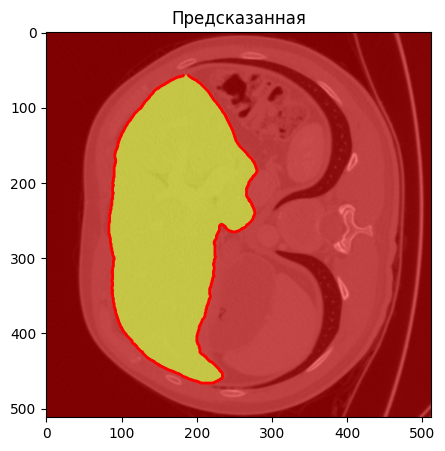

Image shape: 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


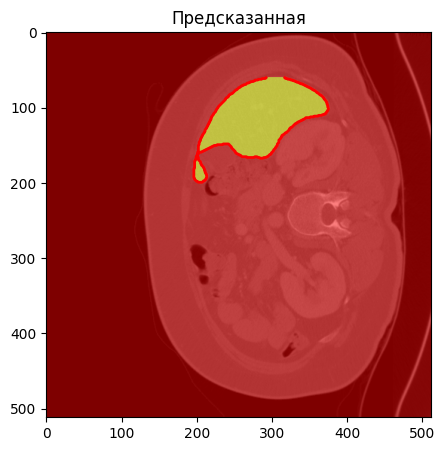

Image shape: 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


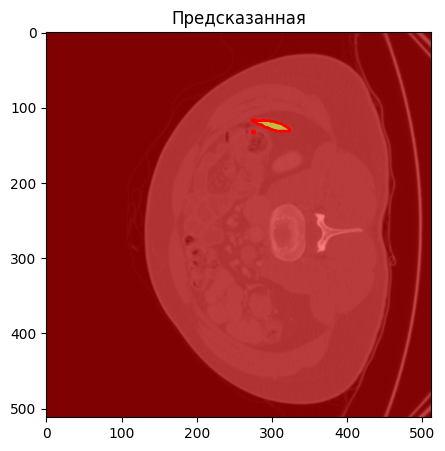

Image shape: 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


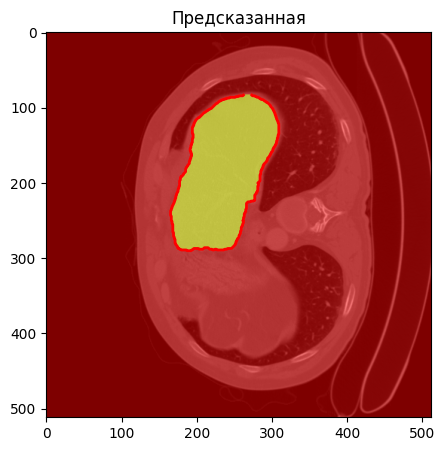

Image shape: 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


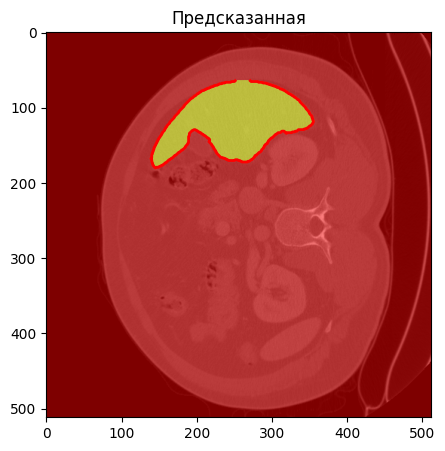

Image shape: 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


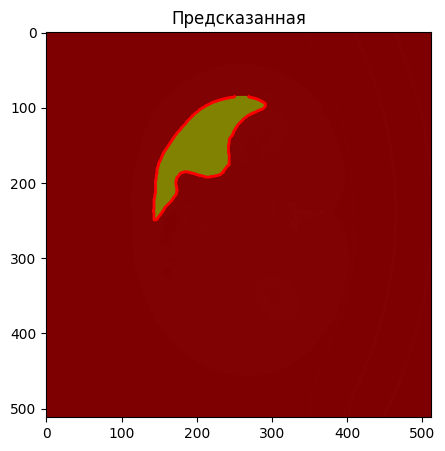

Image shape: 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


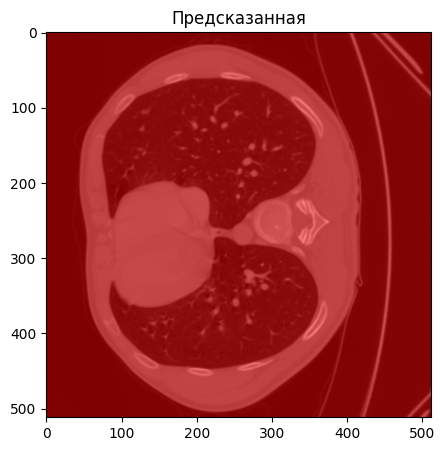

Image shape: 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


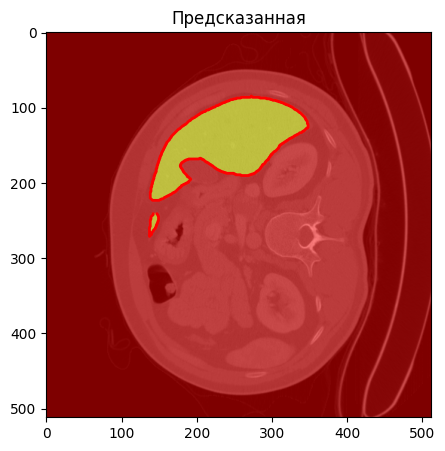

Image shape: 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


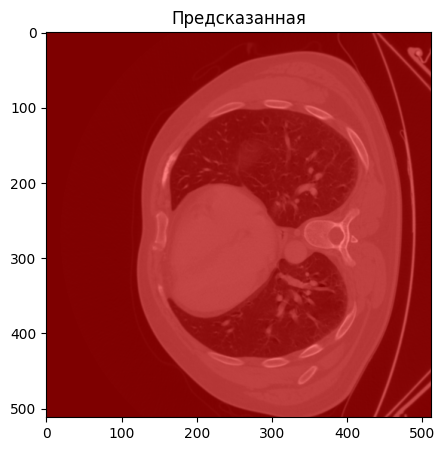

Image shape: 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


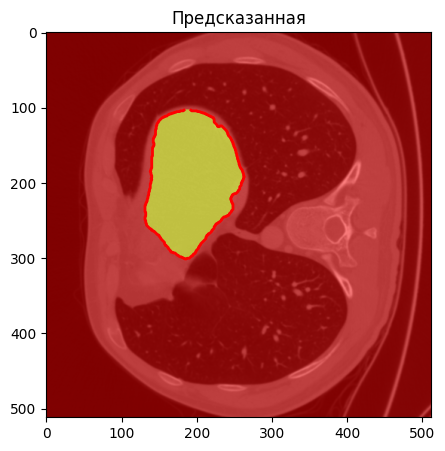

Image shape: 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


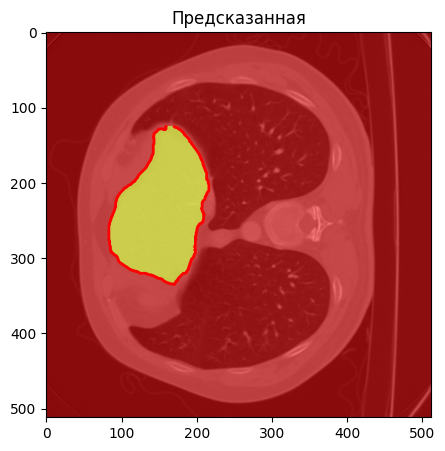

Image shape: 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


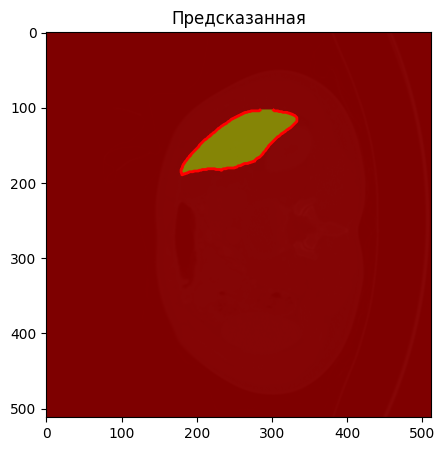

Image shape: 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


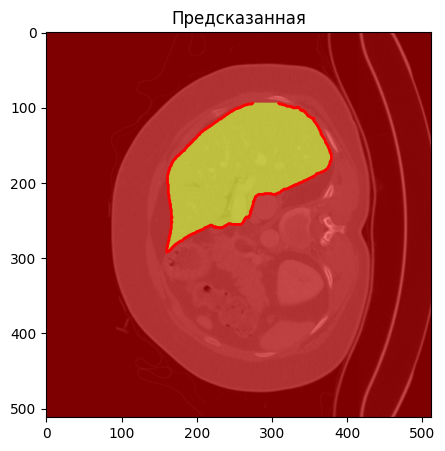

Image shape: 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


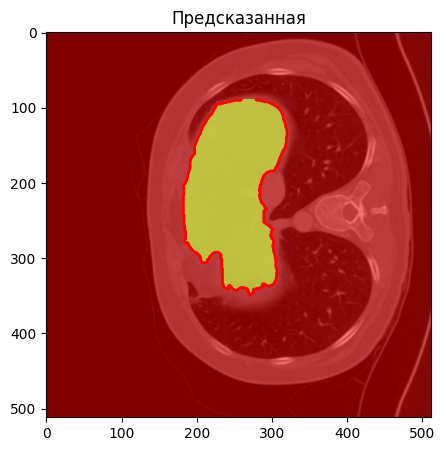

Image shape: 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


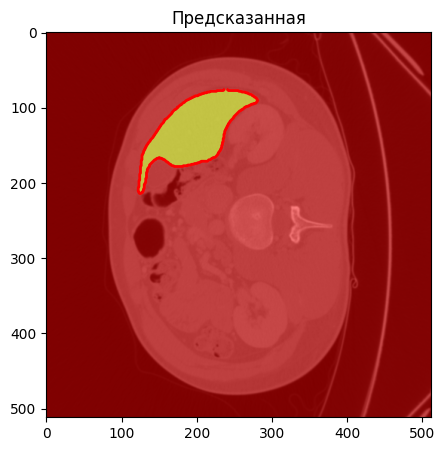

Image shape: 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


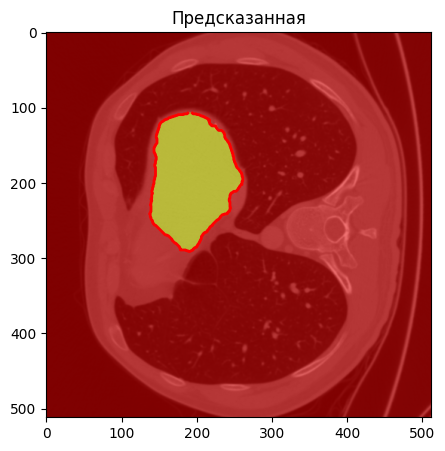

Image shape: 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


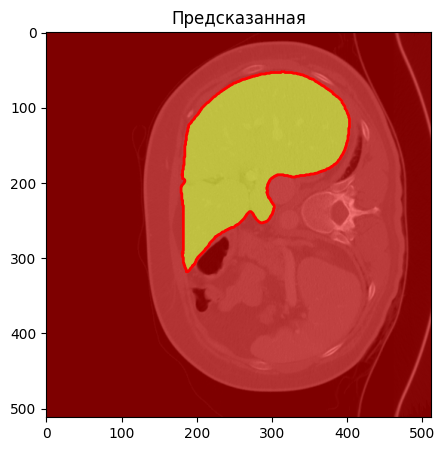

Image shape: 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


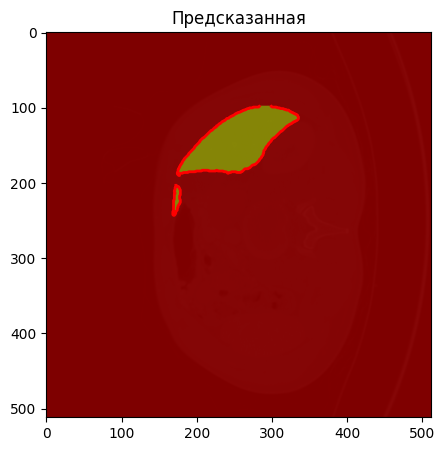

Image shape: 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


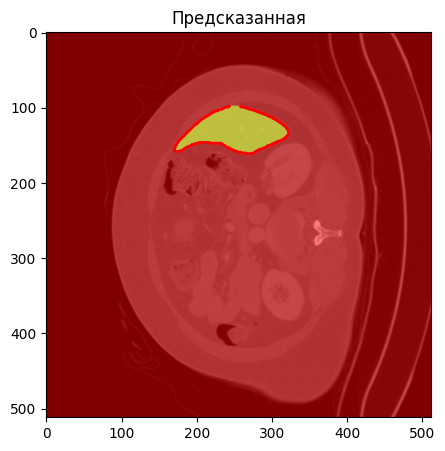

Image shape: 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


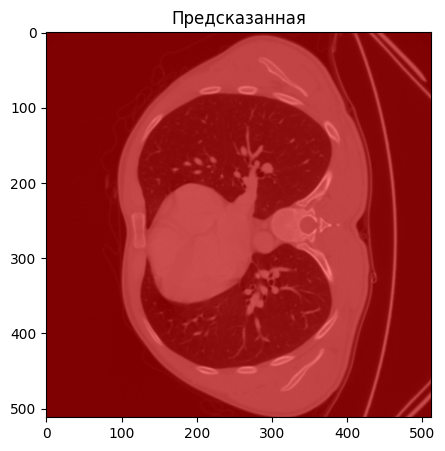

Image shape: 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


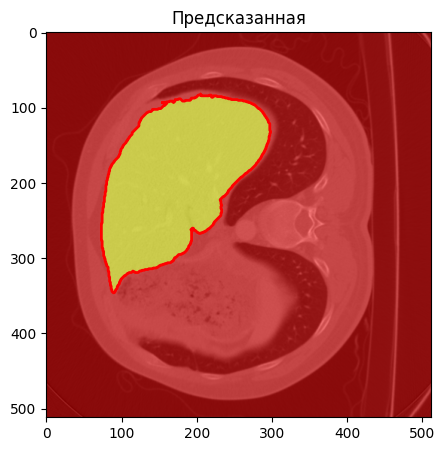

Image shape: 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


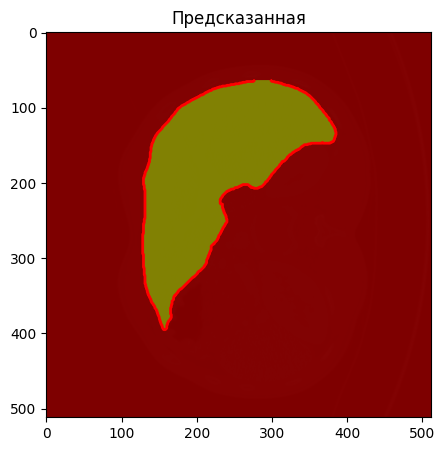

Image shape: 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


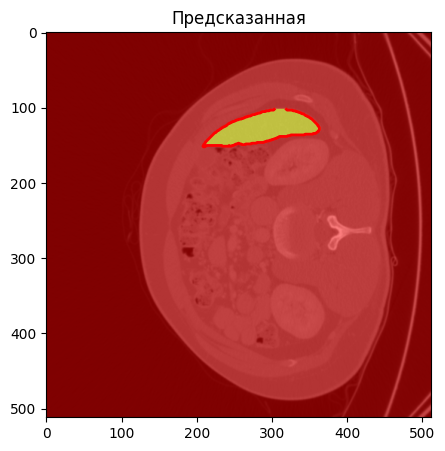

Image shape: 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


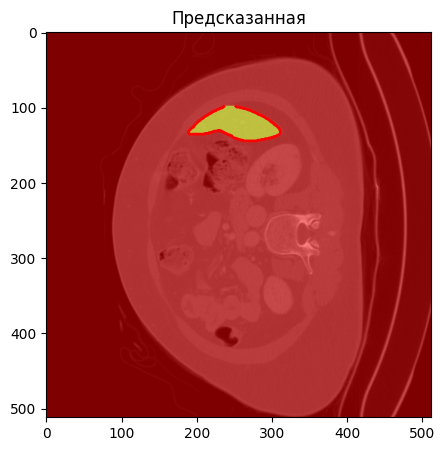

Image shape: 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


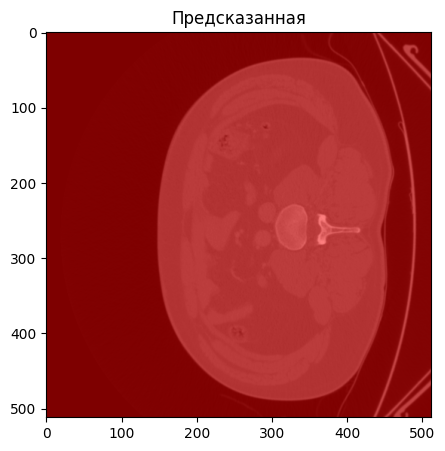

Image shape: 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


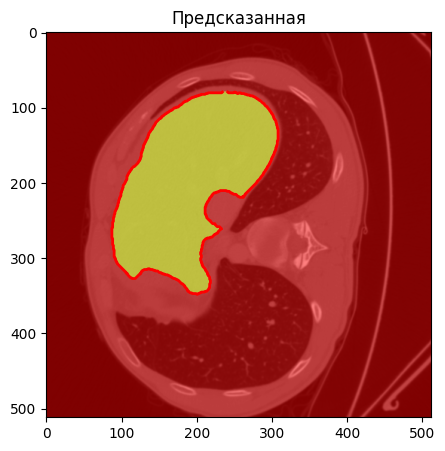

Image shape: 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


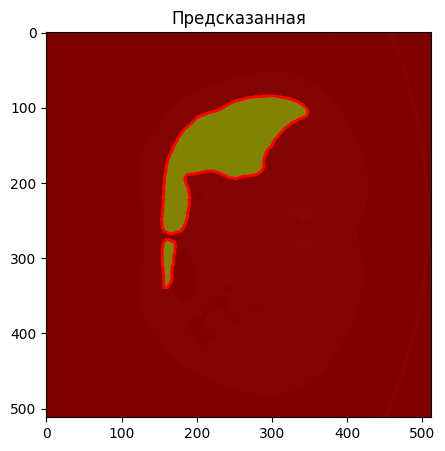

Image shape: 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


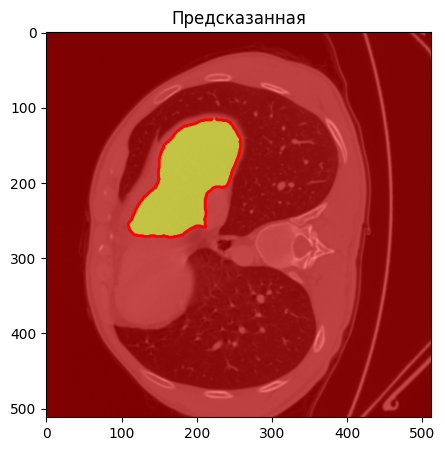

Image shape: 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


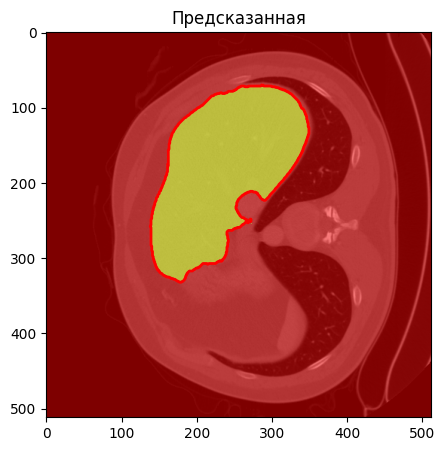

Image shape: 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


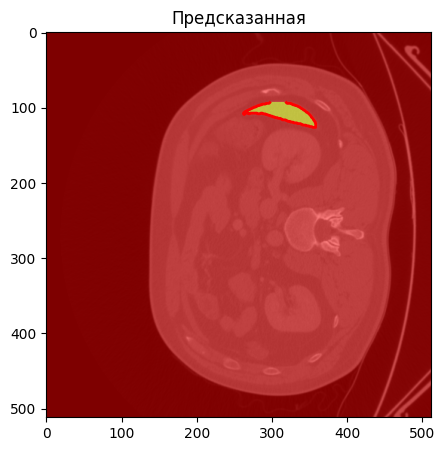

Image shape: 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step


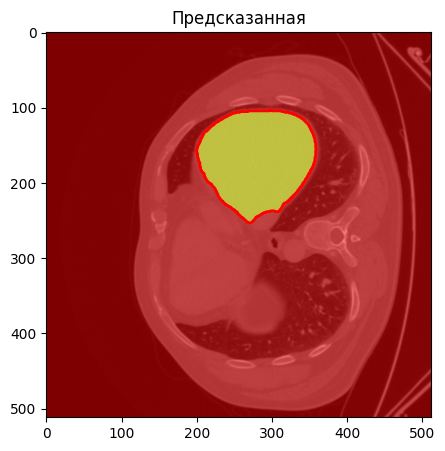

Image shape: 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


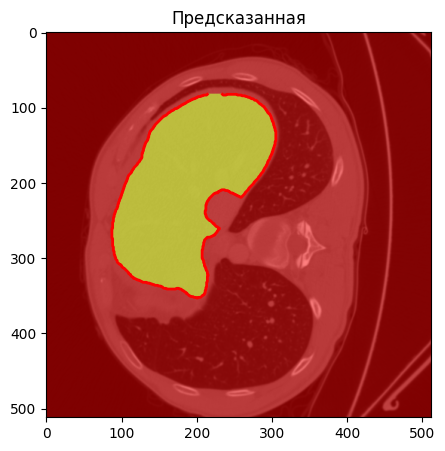

Image shape: 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


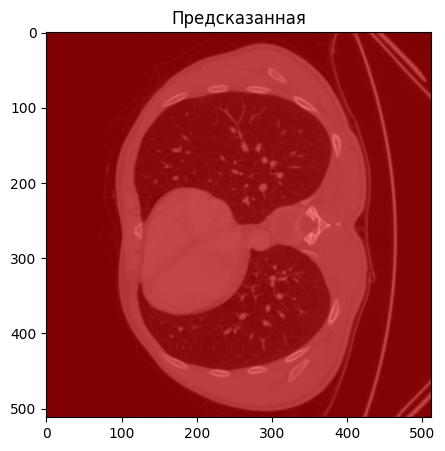

Image shape: 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


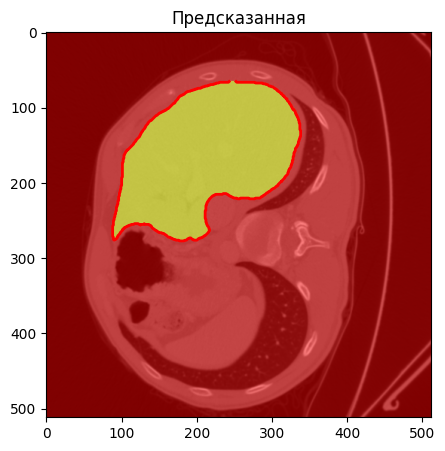

Image shape: 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


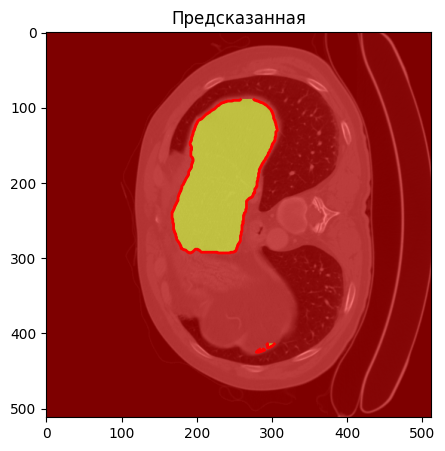

Image shape: 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


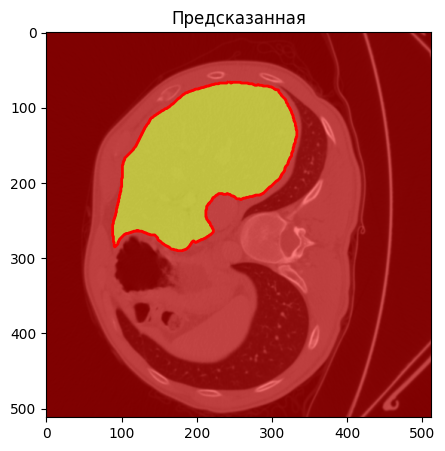

Image shape: 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


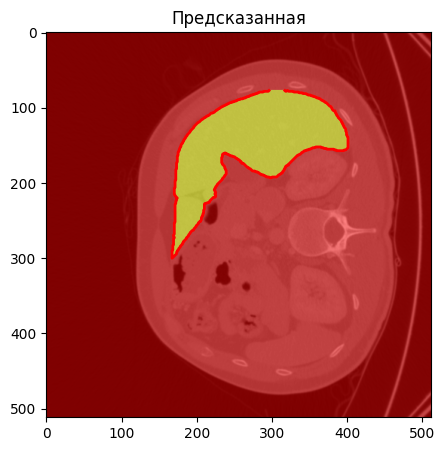

Image shape: 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


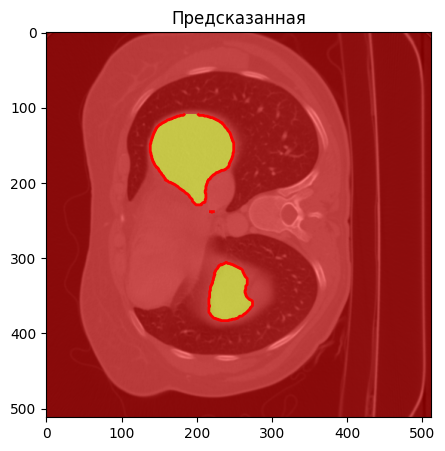

Image shape: 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


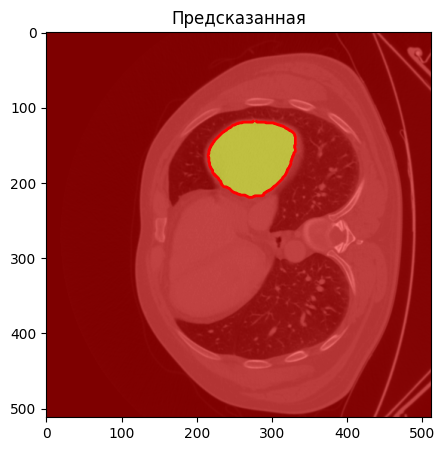

Image shape: 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


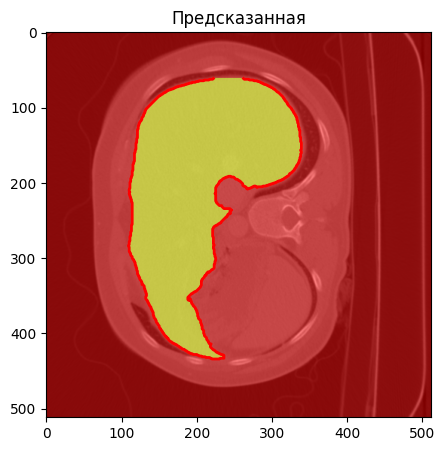

Image shape: 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


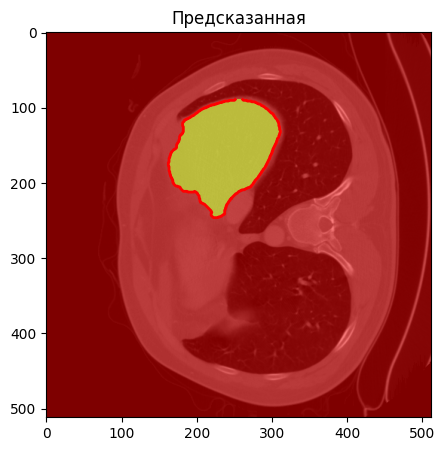

Image shape: 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


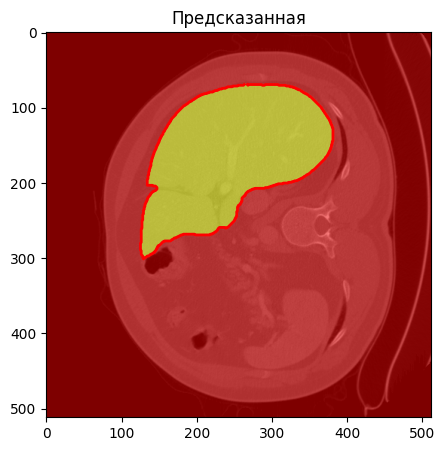

Image shape: 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


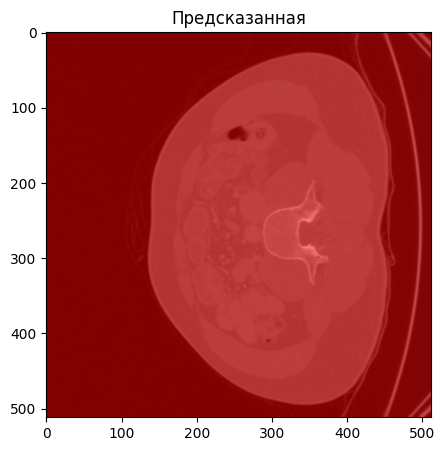

Image shape: 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


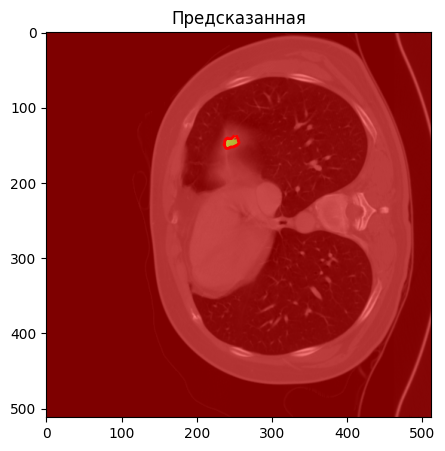

Image shape: 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


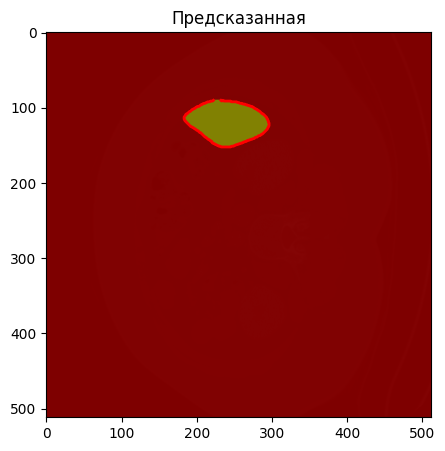

Image shape: 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


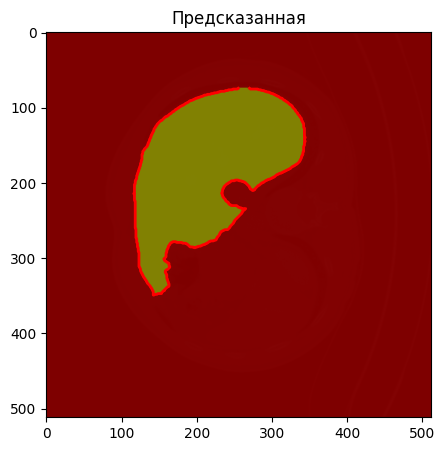

Image shape: 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


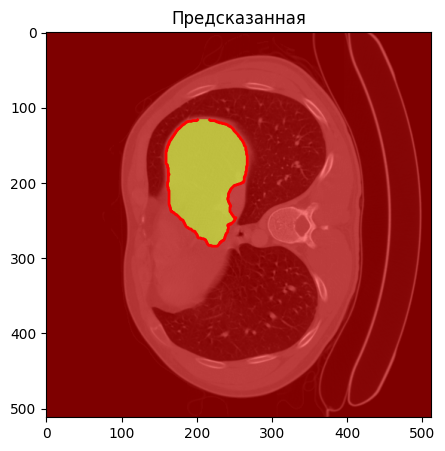

In [ ]:
evaluate(X, plot_pairs=50)